In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanIoU
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
import tensorflow.keras.backend as K
# Enable Mixed Precision
from tensorflow.keras.mixed_precision import Policy
policy = Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)


# Set matplotlib to display inline
%matplotlib inline

# Define Dice Coefficient (if not already included in saved models)
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.cast(K.flatten(y_true), dtype='float32')
    y_pred_f = K.cast(K.flatten(y_pred), dtype='float32')
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        K.sum(y_true_f) + K.sum(y_pred_f) + smooth
    )


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define paths
base_dir = '/content/drive/MyDrive/health_care_project/extracted_files'
test_images_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Test_Data')
test_masks_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Test_GroundTruth')

# Function to load images from a folder
def load_images_from_folder(folder, size=(128, 128)):
    images = []
    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, size)  # Resize for consistency
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            images.append(img)
    return np.array(images)

# Load test images and masks
test_images = load_images_from_folder(test_images_dir)
test_masks = load_images_from_folder(test_masks_dir, size=(128, 128))

# Preprocess data
test_images = test_images / 255.0
test_masks = test_masks / 255.0
test_masks = np.expand_dims(test_masks[:, :, :, 0], axis=3)  # Single-channel masks

print(f'Test Images Shape: {test_images.shape}')
print(f'Test Masks Shape: {test_masks.shape}')


Test Images Shape: (379, 128, 128, 3)
Test Masks Shape: (379, 128, 128, 1)


In [ ]:
# Define model paths
unet_plus_plus_path = '/content/drive/MyDrive/health_care_project/unet_plus_plus_model.keras'
unet_path = '/content/drive/MyDrive/health_care_project/unet_model.keras'
resunet_path = '/content/drive/MyDrive/health_care_project/resunet_model.keras'

# Custom objects (if any, e.g., dice_coef)
custom_objects = {'dice_coef': dice_coef, 'MeanIoU': MeanIoU}

# Load models
print("Loading U-Net++ model...")
unet_plus_plus_model = load_model(unet_plus_plus_path, custom_objects=custom_objects)

print("Loading U-Net model...")
unet_model = load_model(unet_path, custom_objects=custom_objects)

print("Loading ResUNet model...")
resunet_model = load_model(resunet_path, custom_objects=custom_objects)


Loading U-Net++ model...
Loading U-Net model...
Loading ResUNet model...


In [ ]:
# Function to evaluate a model
def evaluate_model(model, test_images, test_masks, model_name="Model"):
    results = model.evaluate(test_images, test_masks, verbose=0)
    loss = results[0]
    metrics = results[1:]
    print(f"--- {model_name} Evaluation ---")
    print(f"Test Loss: {loss:.4f}")
    if len(metrics) > 0:
        for idx, metric in enumerate(model.metrics_names[1:]):
            print(f"Test {metric}: {metrics[idx]:.4f}")
    print("\n")

# Evaluate U-Net++
evaluate_model(unet_plus_plus_model, test_images, test_masks, model_name="U-Net++")

# Evaluate U-Net
evaluate_model(unet_model, test_images, test_masks, model_name="U-Net")

# Evaluate ResUNet
evaluate_model(resunet_model, test_images, test_masks, model_name="ResUNet")


--- U-Net++ Evaluation ---
Test Loss: 0.1503
Test compile_metrics: 0.5203


--- U-Net Evaluation ---
Test Loss: 0.1433
Test compile_metrics: 0.5209


--- ResUNet Evaluation ---
Test Loss: 0.3238
Test compile_metrics: 0.4533




1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


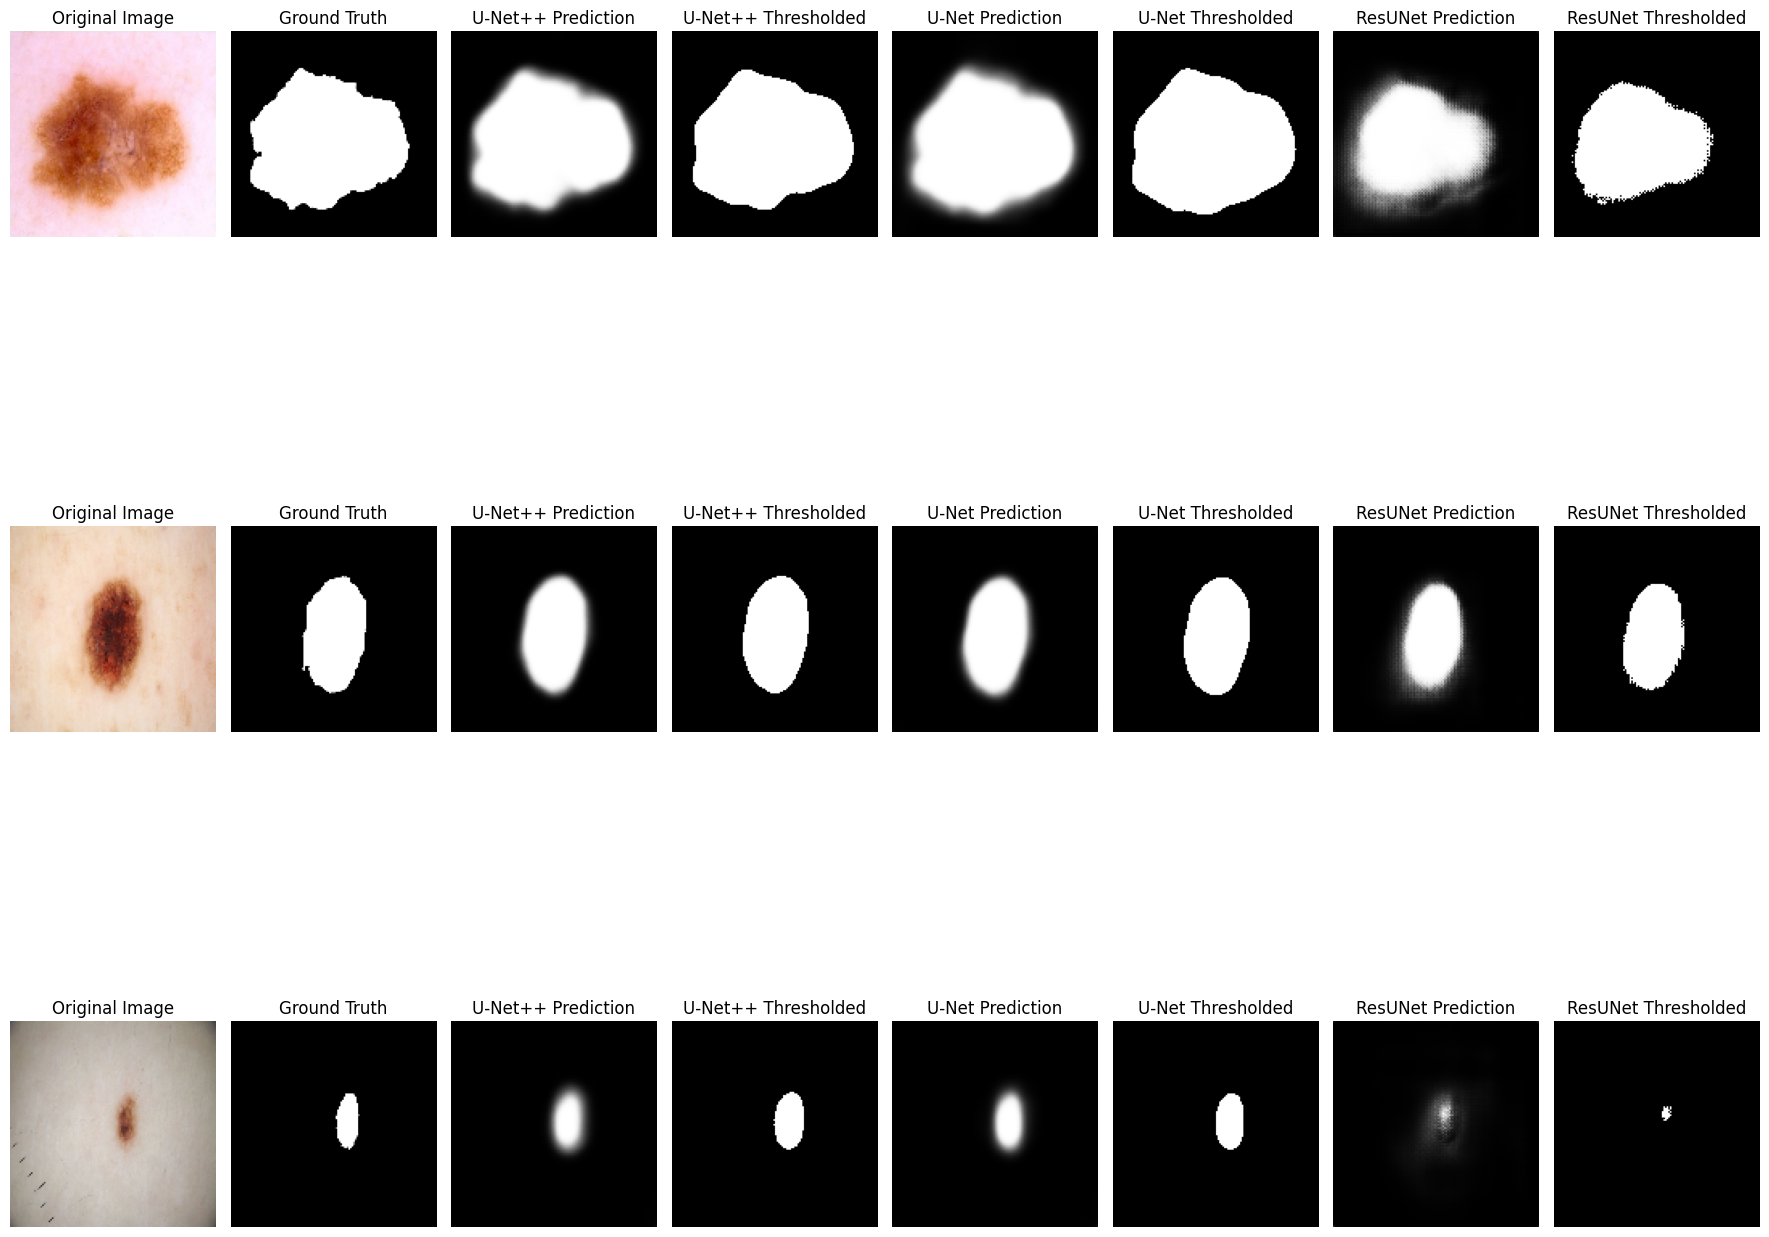

In [ ]:
def display_predictions_comparison(images, masks, models, model_names, num_images=3, threshold=0.5):
    """
    Displays predictions from multiple models side by side.

    Parameters:
    - images: Array of input images.
    - masks: Array of ground truth masks.
    - models: List of models to generate predictions.
    - model_names: List of model names corresponding to the models.
    - num_images: Number of images to display.
    - threshold: Threshold for binary segmentation.
    """
    np.random.seed(51)

    plt.figure(figsize=(20, num_images * 5))
    for i in range(num_images):
        idx = np.random.randint(0, images.shape[0])
        image = images[idx]
        mask = masks[idx]

        # Generate predictions
        predictions = []
        thresholded_predictions = []
        for model in models:
            pred = model.predict(np.expand_dims(image, axis=0))[0, :, :, 0]
            predictions.append(pred)
            thresholded_predictions.append((pred > threshold).astype(np.float32))

        # Display Original Image
        plt.subplot(num_images, (2 + len(models)*2) + 1, i*( (2 + len(models)*2) +1 ) + 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')

        # Display Ground Truth
        plt.subplot(num_images, (2 + len(models)*2) + 1, i*( (2 + len(models)*2) +1 ) + 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        # Display Predictions for each model
        for j, (pred, pred_thresh) in enumerate(zip(predictions, thresholded_predictions)):
            # Prediction Probability
            plt.subplot(num_images, (2 + len(models)*2) + 1, i*( (2 + len(models)*2) +1 ) + 3 + j*2)
            plt.imshow(pred, cmap='gray')
            plt.title(f'{model_names[j]} Prediction')
            plt.axis('off')

            # Thresholded Prediction
            plt.subplot(num_images, (2 + len(models)*2) + 1, i*( (2 + len(models)*2) +1 ) + 4 + j*2)
            plt.imshow(pred_thresh, cmap='gray')
            plt.title(f'{model_names[j]} Thresholded')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Define models and their names
models = [unet_plus_plus_model, unet_model, resunet_model]
model_names = ["U-Net++", "U-Net", "ResUNet"]

# Display predictions
display_predictions_comparison(test_images, test_masks, models, model_names, num_images=3)
